# Bachelor Thesis: Automated Image Quality Assessment in Teledermatology

___
Choekyel Nyungmartsang

**About IQA**

* ToDo

## ARNIQA: A Method Overview for Image Quality Assessment

ARNIQA (learning distoRtion maNifold for Image Quality Assessment) is a self-supervised approach designed to assess image quality by modeling the image distortion manifold to obtain quality representations in an intrinsic manner. 

The methodology involves three key steps:

1. Image Degradation Modeling: ARNIQA introduces an image degradation model that randomly composes ordered sequences of consecutively applied distortions. This allows for the synthetic degradation of images with a wide variety of degradation patterns.

2. Representation Learning: The model is trained by maximizing the similarity between the representations of patches of different images distorted equally, despite varying content. Consequently, images degraded in the same manner correspond to neighboring positions within the distortion manifold.

3. Quality Score Mapping: ARNIQA maps the image representations to quality scores using a simple linear regressor, without fine-tuning the encoder weights.

Experiments demonstrate that ARNIQA achieves state-of-the-art performance on various datasets, showcasing improved data efficiency, generalization capabilities, and robustness compared to competing methods.

While originally developed for the general image domain, ARNIQA's methodology is applicable to other domains. This includes teledermatology, where the assessment of image quality plays a critical role in accurate diagnosis and treatment. By adapting and finetuning ARNIQA on dermatology datasets, it holds the potential to enhance quality assessment in teledermatology applications.


## Dataset Overview

* ToDO

## Which pretrained model to choose

1. Speed - how fast does it run? 
2. Size - how big is the model? (Parameter)
3. Performance - how well does it go on your chosen problem (how well does it assess the quality of an image)

-> High accuracy and low parameter

## Importing Libraries

In [1]:
!pip install -q pandas seaborn scikit-plot scikit-image wandb torch-summary

In [4]:
!pip3 install -q torchvision # restart kernel

  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/3a/49/12fc5188602c68a789a0fdaee63d176a71ad5c1e34d25aeb8554abe46089/torchvision-0.17.1-cp311-cp311-manylinux1_x86_64.whl.metadata
  Using cached torchvision-0.17.1-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
  Obtaining dependency information for torch==2.2.1 from https://files.pythonhosted.org/packages/2c/df/5810707da6f2fd4be57f0cc417987c0fa16a2eecf0b1b71f82ea555dc619/torch-2.2.1-cp311-cp311-manylinux1_x86_64.whl.metadata
  Using cached torch-2.2.1-cp311-cp311-manylinux1_x86_64.whl.metadata (26 kB)
  Obtaining dependency information for typing-extensions>=4.8.0 from https://files.pythonhosted.org/packages/f9/de/dc04a3ea60b22624b51c703a84bbe0184abcd1d0b9bc8074b5d6b7ab90bb/typing_extensions-4.10.0-py3-none-any.whl.metadata
  Using cached typing_extensions-4.10.0-py3-none-any.whl.metadata (3.0 kB)
  Obtaining dependency information for nvidia-cuda-nvrtc-cu12==12.1.105 from https://files

In [1]:
import time
import os
import copy

import numpy as np
import PIL as PIL
from PIL import Image
import pandas as pd
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
import random
import math
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils import data
from torch.utils.data import Subset
from torchvision.io import read_image
from torch.utils.data import DataLoader

import wandb

In [2]:
torchvision.__version__

'0.17.2+cu121'

## Global Settings

In [3]:
TEST_DIR = 'test_folder'

BATCH_SIZE = 4
NUM_WORKERS = 2

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
TRACK = False

if TRACK:
    wandb.login()
    # wandb.login(anonymous=anonymous, relogin=True)

## Preparing Test Dataset

In [7]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

image_dataset = torchvision.datasets.ImageFolder(TEST_DIR, transform=preprocess)

#dataloaders = torch.utils.data.DataLoader(image_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

dataset_size = len(image_dataset)

class_names = image_dataset.classes

print(f"Classes: {class_names}, Length: {dataset_size}")

Classes: ['blur', 'good_quality', 'low_resolution', 'poor_lighting', 'too_far_away'], Length: 239


## Getting Pretrained Model and Regressor

In [5]:
with open("scin_regressor_0.21544346900318834.pkl", "rb") as f:
    regressor = pickle.load(f)
arniqa = torch.hub.load(repo_or_dir="miccunifi/ARNIQA", source="github", model="ARNIQA")
arniqa.eval().to(DEVICE)
next(arniqa.parameters()).is_cuda

Using cache found in /home/jovyan/.cache/torch/hub/miccunifi_ARNIQA_main


True

## Evaluation

In [8]:
def tensor2image(image, mean_values=[0.485, 0.456, 0.406], std_values=[0.229, 0.224, 0.225]):
    """Imshow for Tensor."""

    # Set the color channel as the third dimension
    image = image.cpu().numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array(mean_values)
    std = np.array(std_values)
    image = std * image + mean  # unormalise image

    # Clip the image pixel values to [0, 1]
    image = np.clip(image, 0, 1)

    return image

In [9]:
# Create a dictionary to store the image paths for each class
class_image_paths = {class_name: [] for class_name in class_names}

# Iterate over the dataset to populate the class_image_paths dictionary
for image_path, label in image_dataset.imgs:
    class_name = class_names[label]
    class_image_paths[class_name].append(image_path)
    
num_rows = 1
num_cols = len(class_names)

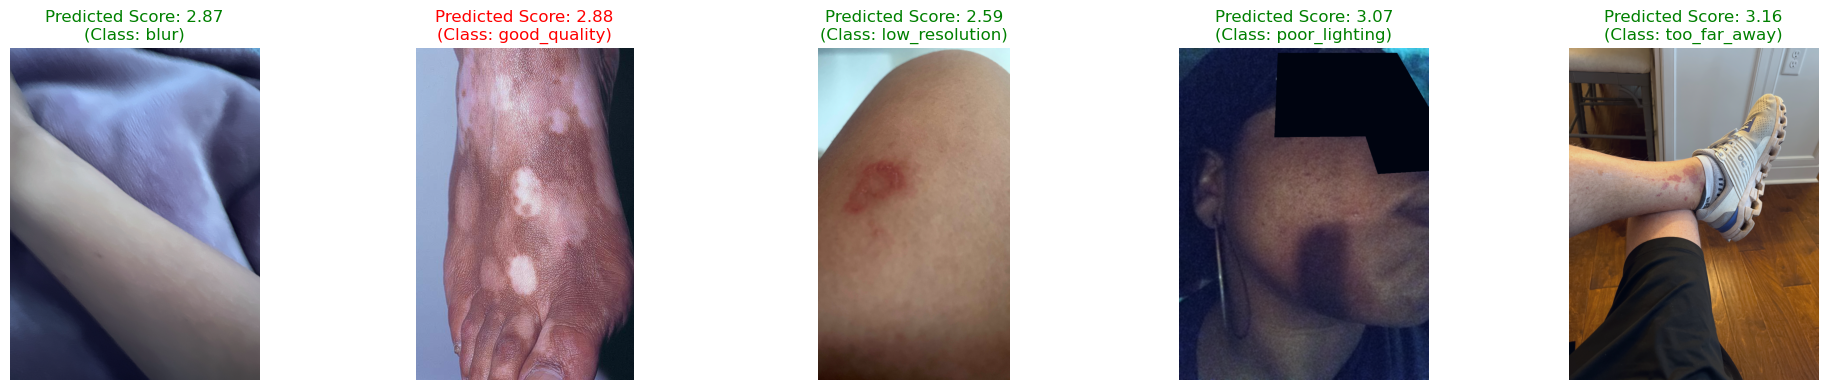

In [10]:
fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))
for class_idx, class_name in enumerate(class_names):
    # Get a random image path from the current class
    random_image_path = random.choice(class_image_paths[class_name])
    
    # Load and preprocess the image
    img = Image.open(random_image_path).convert('RGB')
    img_ds = transforms.Resize((img.size[1] // 2, img.size[0] // 2))(img)
    
    img = preprocess(img).unsqueeze(0).to(DEVICE)
    img_ds = preprocess(img_ds).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        _, features = arniqa(img, img_ds, return_embedding=True, scale_score=True)
        features = features.cpu().numpy()
        predicted_score = regressor.predict(features)[0]
    
    # Determine the color based on the predicted score and class name
    if (predicted_score >= 4.0 and class_name == 'good_quality') or \
       (predicted_score <= 3.5 and class_name in ['blur', 'low_resolution', 'poor_lighting', 'too_far_away']):
        color = "green"
    else:
        color = "red"
    
    # Plot the image and display the predicted score
    ax = fig.add_subplot(num_rows, num_cols, class_idx + 1)
    img = img.squeeze().cpu().permute(1, 2, 0)  # Convert back to numpy array
    img = (img - img.min()) / (img.max() - img.min())  # Normalize pixel values to [0, 1]
    ax.imshow(img)  # Display the image
    ax.set_title(f"Predicted Score: {predicted_score:.2f}\n(Class: {class_name})", fontsize=12, color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()

| IQA Rating      | Dermatologist Confidence                  | Description                                             |
|-----------------|-------------------------------------------|-----------------------------------------------------------------------------------------|
| 1 (Bad)         | Not tolerable artifacts or degredations   | Less than 25% confidence - Just providing best guess   |
|-----------------|-------------------------------------------|-----------------------------------------------------------------------------------------|
| 2 (Poor)        | Tolerable artifacts or degredation        | Between 25%-50% confidence - Conflicted between 2 or more diagnoses, not confident          |
|-----------------|-------------------------------------------|-----------------------------------------------------------------------------------------|
| 3 (Fair)        | Some distortions                          | Between 50%-75% confidence - Fairly confident, but up to half of colleagues may disagree    |
|-----------------|-------------------------------------------|-----------------------------------------------------------------------------------------|
| 4 (Good)        | Observed distortions                      | Between 75%-90% confidence - Not classic for condition, but very confident in diagnosis            |
|-----------------|-------------------------------------------|-----------------------------------------------------------------------------------------|
| 5 (Excellent)   | No distortions                            | Greater than 90% confidence - Classic for condition     |
           

# Test on Pretrained ARNIQA

In [11]:
model = torch.hub.load(repo_or_dir="miccunifi/ARNIQA", source="github", model="ARNIQA", regressor_dataset="kadid10k")    # You can choose any of the available datasets
model.eval().to(DEVICE)
next(model.parameters()).is_cuda

Using cache found in /home/jovyan/.cache/torch/hub/miccunifi_ARNIQA_main


True

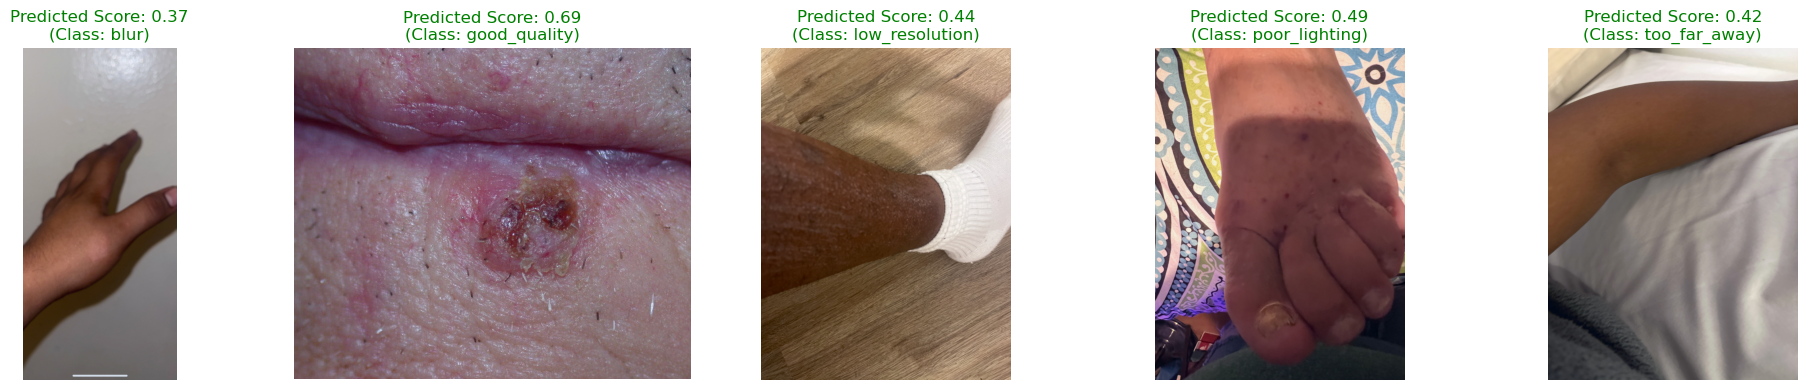

In [12]:
fig = plt.figure(figsize=(num_cols * 4, num_rows * 4))
for class_idx, class_name in enumerate(class_names):
    # Get a random image path from the current class
    random_image_path = random.choice(class_image_paths[class_name])
    
    # Load and preprocess the image
    img = Image.open(random_image_path).convert('RGB')
    img_ds = transforms.Resize((img.size[1] // 2, img.size[0] // 2))(img)
    
    img = preprocess(img).unsqueeze(0).to(DEVICE)
    img_ds = preprocess(img_ds).unsqueeze(0).to(DEVICE)
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        score = model(img, img_ds, return_embedding=False, scale_score=True)
        predicted_score = score.item()
    
    # Determine the color based on the predicted score and class name
    if (predicted_score >= 0.5 and class_name == 'good_quality') or \
       (predicted_score <= 0.5 and class_name in ['blur', 'low_resolution', 'poor_lighting', 'too_far_away']):
        color = "green"
    else:
        color = "red"
    
    # Plot the image and display the predicted score
    ax = fig.add_subplot(num_rows, num_cols, class_idx + 1)
    img = img.squeeze().cpu().permute(1, 2, 0)  # Convert back to numpy array
    img = (img - img.min()) / (img.max() - img.min())  # Normalize pixel values to [0, 1]
    ax.imshow(img)  # Display the image
    ax.set_title(f"Predicted Score: {predicted_score:.2f}\n(Class: {class_name})", fontsize=12, color=color)
    ax.axis('off')

plt.tight_layout()
plt.show()